## Binning and Aggregation

We have discussed **data**, **marks**, **encodings**, and **encoding types**.
The next essential piece of Altair's API is its approach to binning and aggregating data

In [1]:
import altair as alt

# Altair plots render by default in JupyterLab and nteract

# Uncomment/run this line to enable Altair in the classic notebook (not in JupyterLab)
# alt.renderers.enable('notebook')

# Uncomment/run this line to enable Altair in Colab
# alt.renderers.enable('colab')

In [2]:
from vega_datasets import data
cars = data.cars()

cars.head()

,Acceleration,Cylinders,Displacement,Horsepower,Miles_per_Gallon,Name,Origin,Weight_in_lbs,Year
0,12.0,8,307.0,130.0,18.0,chevrolet chevelle malibu,USA,3504,1970-01-01
1,11.5,8,350.0,165.0,15.0,buick skylark 320,USA,3693,1970-01-01
2,11.0,8,318.0,150.0,18.0,plymouth satellite,USA,3436,1970-01-01
3,12.0,8,304.0,150.0,16.0,amc rebel sst,USA,3433,1970-01-01
4,10.5,8,302.0,140.0,17.0,ford torino,USA,3449,1970-01-01


### Group-By in Pandas

One key operation in data exploration is the *group-by*, discussed in detail in [Chaper 4](https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html) of the *Python Data Science Handbook*.
In short, the group-by *splits* the data according to some condition, *applies* some aggregation within those groups, and then *combines* the data back together:

<img src="split-apply-combine.png">
<small>[Figure source](https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html)</small>

For the cars data, you might split by Origin, compute the mean of the miles per gallon, and then combine the results.
In Pandas, the operation looks like this:

In [3]:
cars.groupby('Origin')['Miles_per_Gallon'].mean()

Origin
Europe    27.891429
Japan     30.450633
USA       20.083534
Name: Miles_per_Gallon, dtype: float64

In Altair, this sort of split-apply-combine can be performed by passing an aggregation operator within a string to any encoding. For example, we can display a plot representing the above aggregation as follows:

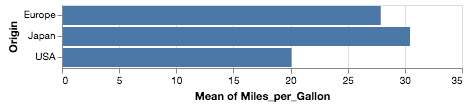

In [4]:
alt.Chart(cars).mark_bar().encode(
    y='Origin',
    x='mean(Miles_per_Gallon)'
)

Notice that the grouping is done implicitly within the encodings: here we group only by Origin, then compute the mean over each group.

### One-dimensional Binnings: Histograms

One of the most common uses of binning is the creation of histograms. For example, here is a histogram of miles per gallon:

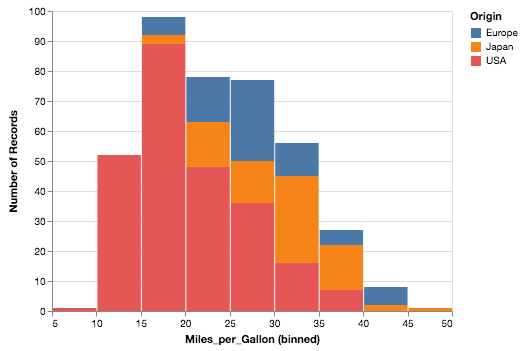

In [5]:
alt.Chart(cars).mark_bar().encode(
    alt.X('Miles_per_Gallon', bin=True),
    alt.Y('count()'),
    alt.Color('Origin')
)

One interesting thing that Altair's declarative approach allows is to start assigning these values to different encodings, to see other views of the exact same data.

So, for example, if we assign the binned miles per gallon to the color, we get this view of the data:

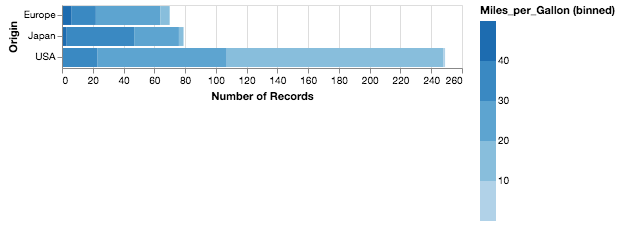

In [6]:
alt.Chart(cars).mark_bar().encode(
    color=alt.Color('Miles_per_Gallon', bin=True),
    x='count()',
    y='Origin'
)

This gives us a better appreciation of the proportion of MPG *within* each country.

If we wish, we can normalize the counts on the x-axis to compare proportions directly:

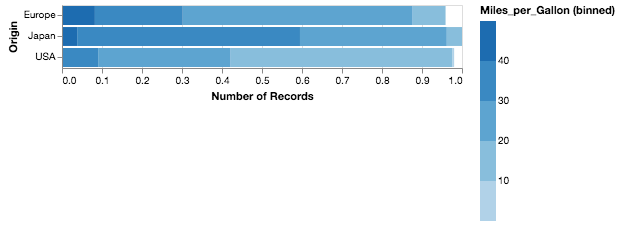

In [7]:
alt.Chart(cars).mark_bar().encode(
    color=alt.Color('Miles_per_Gallon', bin=True),
    x=alt.X('count()', stack='normalize'),
    y='Origin'
)

We see that well over half of US cars were in the "low mileage" category.

Changing the encoding again, let's map the color to the count instead:

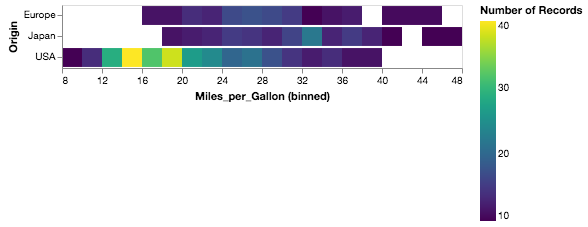

In [8]:
alt.Chart(cars).mark_rect().encode(
    x=alt.X('Miles_per_Gallon', bin=alt.Bin(maxbins=20)),
    color='count()',
    y='Origin',
)

Now we see the same dataset as a heat map!

This is one of the beautiful things about Altair: it shows you through its API grammar the relationships between different chart types: for example, a 2D heatmap encodes the same data as a stacked histogram!

### Other aggregates

Aggregates can also be used with data that is only implicitly binned.
For example, look at this plot of MPG over time:

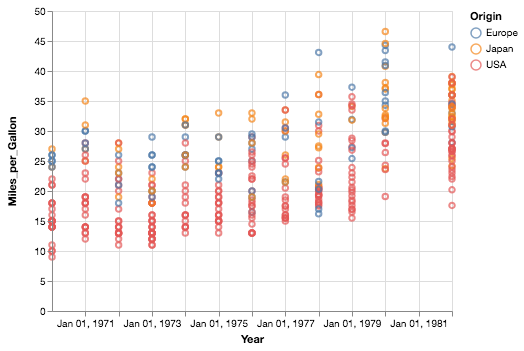

In [9]:
alt.Chart(cars).mark_point().encode(
    x='Year:T',
    color='Origin',
    y='Miles_per_Gallon'
)

The fact that the points overlap so much makes it difficult to see important parts of the data; we can make it clearer by plotting the mean in each group (here, the mean of each Year/Country combination):

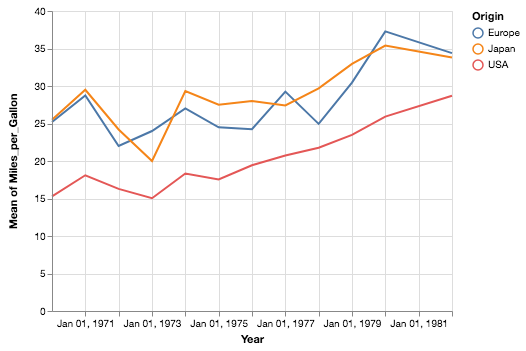

In [10]:
alt.Chart(cars).mark_line().encode(
    x='Year:T',
    color='Origin',
    y='mean(Miles_per_Gallon)'
)

The ``mean`` aggregate only tells part of the story, though: Altair also provides built-in tools to compute the lower and upper bounds of confidence intervals on the mean.

We can use ``mark_area()`` here, and specify the lower and upper bounds of the area using ``y`` and ``y2``:

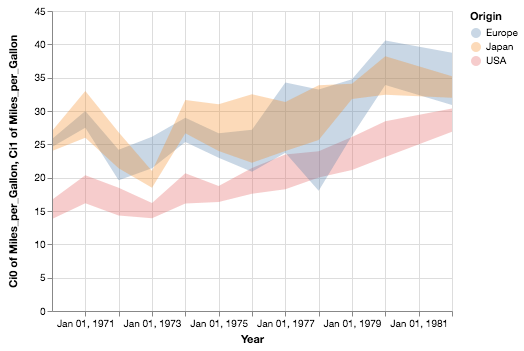

In [11]:
alt.Chart(cars).mark_area(opacity=0.3).encode(
    x='Year:T',
    color='Origin',
    y='ci0(Miles_per_Gallon)',
    y2='ci1(Miles_per_Gallon)'
)

## Time Binnings with *timeUnit*

One special kind of binning is the grouping of temporal values by aspects of the date: for example, month of year, or day of months.
To explore this, let's look at a simple dataset consisting of average temperatures in Seattle:

In [12]:
temps = data.seattle_temps()
temps.head()

,date,temp
0,2010-01-01 00:00:00,39.4
1,2010-01-01 01:00:00,39.2
2,2010-01-01 02:00:00,39.0
3,2010-01-01 03:00:00,38.9
4,2010-01-01 04:00:00,38.8


If we try to plot this data with Altair, we will get a ``MaxRowsError``:

In [13]:
alt.Chart(temps).mark_line().encode(
    x='date:T',
    y='temp:Q'
)

MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

Chart({
  data:                     date  temp
  0    2010-01-01 00:00:00  39.4
  1    2010-01-01 01:00:00  39.2
  2    2010-01-01 02:00:00  39.0
  3    2010-01-01 03:00:00  38.9
  4    2010-01-01 04:00:00  38.8
  5    2010-01-01 05:00:00  38.7
  6    2010-01-01 06:00:00  38.7
  7    2010-01-01 07:00:00  38.6
  8    2010-01-01 08:00:00  38.7
  9    2010-01-01 09:00:00  39.2
  10   2010-01-01 10:00:00  40.1
  11   2010-01-01 11:00:00  41.3
  12   2010-01-01 12:00:00  42.5
  13   2010-01-01 13:00:00  43.2
  14   2010-01-01 14:00:00  43.5
  15   2010-01-01 15:00:00  43.3
  16   2010-01-01 16:00:00  42.7
  17   2010-01-01 17:00:00  41.7
  18   2010-01-01 18:00:00  41.2
  19   2010-01-01 19:00:00  40.9
  20   2010-01-01 20:00:00  40.7
  21   2010-01-01 21:00:00  40.4
  22   2010-01-01 22:00:00  40.2
  23   2010-01-01 23:00:00  39.9
  24   2010-01-02 00:00:00  39.6
  25   2010-01-02 01:00:00  39.4
  26   2010-01-02 02:00:00  39.3
  27   2010-01-02 03:00:00  39.1
  28   2010-01-02 04:00:00  3

In [14]:
len(temps)

8759

### Aside: How Altair Encodes Data

We chose to raise a MaxRowsError for datasets larger than 5000 rows because of our observation of students using Altair, because unless you think about how your data is being represented, it's quite easy to end up with **very** large notebooks inwhich performance will suffer.

When you pass a pandas dataframe to an Altair chart, the result is that the data is converted to JSON and stored in the chart specification. This specification is then embedded in the output of your notebook, and if you make a few dozen charts this way with a large enough dataset, it can significantly slow down your machine.

So how to get around the error? A few ways:

1) Use a smaller dataset. For example, we could use Pandas to aggregate the temperatures by day:
   ```python
   import pandas as pd
   temps = temps.groupby(pd.DatetimeIndex(temps.date).date).mean().reset_index()
   ```

2) Store the data to file, and reference the data by filename instead. This lets us plot the full dataset without having to embed it in the notebook.

3) Disable the MaxRowsError using
   ```python
   alt.data_transformers.enable('default', max_rows=None)
   ```
   But note this can lead to *very* large notebooks if you're not careful.

4) Automatically load the data from disk using
   ```python
   alt.data_transformers.enable('json')
   ```
   which will automatically save the data to file and provide the url of that file to the chart each time a chart is created.


We'll do the latter here, which is the most convenient and leads to the best performance:

In [15]:
temps = temps.sample(4999)

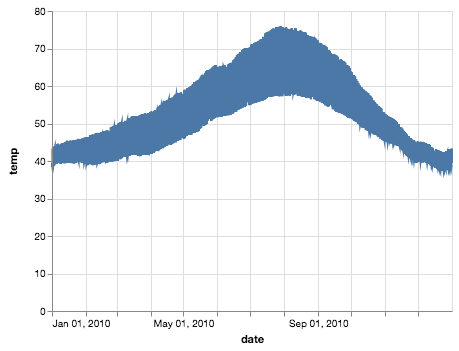

In [17]:
alt.Chart(temps).mark_line().encode(
    x='date:T',
    y='temp:Q'
)

This data is a little bit crowded; suppose we would like to bin this data by month. We'll do this using the ``timeUnit`` argument on the date:

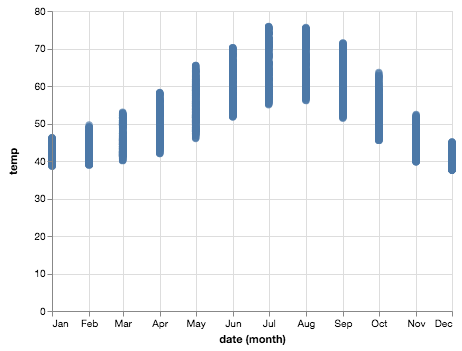

In [18]:
alt.Chart(temps).mark_point().encode(
    x=alt.X('date:T', timeUnit='month'),
    y='temp:Q'
)

This might be clearer if we now aggregate the temperatures:

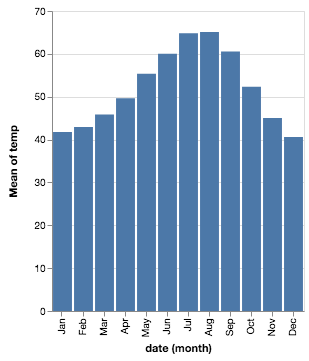

In [19]:
alt.Chart(temps).mark_bar().encode(
    x=alt.X('date:O', timeUnit='month'),
    y='mean(temp):Q'
)

We can also split dates two different ways to produce interesting views of the data; for example:

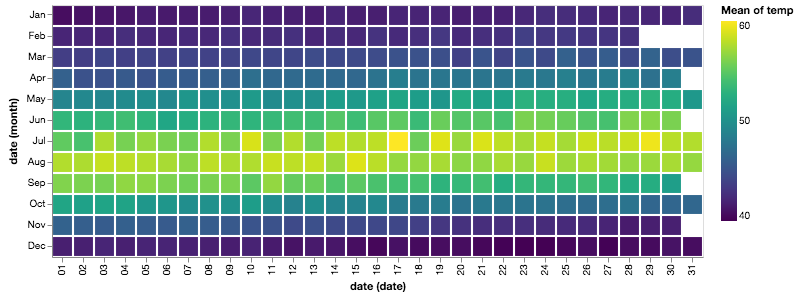

In [20]:
alt.Chart(temps).mark_rect().encode(
    x=alt.X('date:O', timeUnit='date'),
    y=alt.Y('date:O', timeUnit='month'),
    color='mean(temp):Q'
)

Or we can look at the hourly average temperature as a function of month:

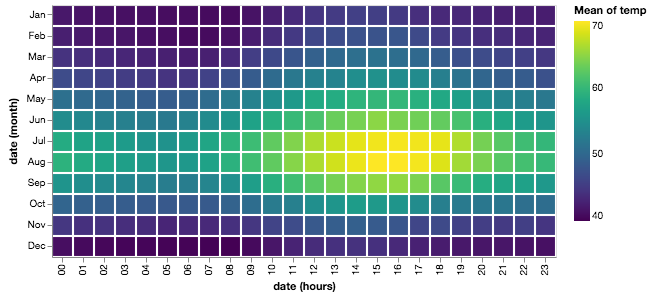

In [21]:
alt.Chart(temps).mark_rect().encode(
    x=alt.X('date:O', timeUnit='hours'),
    y=alt.Y('date:O', timeUnit='month'),
    color='mean(temp):Q'
)

This kind of transform can be quite useful when working with temporal data.

More information on ``timeUnit`` is available here: https://altair-viz.github.io/user_guide/transform.html#timeunit-transform